In [23]:
import os.path as op
import pandas as pd
import numpy as np

import mne
%matplotlib inline
%config InlineBackend.figure_format = "png"
from mne import combine_evoked
from mne.minimum_norm import apply_inverse
from mne.datasets.brainstorm import bst_auditory
from mne.io import read_raw_ctf

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (14.0, 8.0)

### Experiment:

* One subject, 2 acquisition runs 6 minutes each.
* Each run contains 200 regular beeps and 40 easy deviant beeps.
* Random ISI: between 0.7s and 1.7s seconds, uniformly distributed.
* Button pressed when detecting a deviant with the right index finger.

### Acquisition:
Data channel array consisted of 274 MEG axial gradiometers, 26 MEG reference sensors and 2 EEG electrodes (Cz and Pz). In addition:

* 1 stim channel for marking presentation times for the stimuli
* 1 audio channel for the sent signal
* 1 response channel for recording the button presses
* 1 ECG bipolar
* 2 EOG bipolar (vertical and horizontal)
* 12 head tracking channels
* 20 unused channels

In [4]:
# settings for the tutorial
use_precomputed = True

preload = not use_precomputed

scalings = dict(mag=1e-12, grad=4e-11, eeg=20e-5, eog=150e-6, ecg=5e-4,
                emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1,
                resp=1, chpi=1e-4, whitened=1e2)
# file paths
data_path = bst_auditory.data_path()
subject = 'bst_auditory'
subjects_dir = op.join(data_path, 'subjects')

raw_fname1 = op.join(data_path, 'MEG', 'bst_auditory',
                     'S01_AEF_20131218_01.ds')

raw_fname2 = op.join(data_path, 'MEG', 'bst_auditory',
                     'S01_AEF_20131218_02.ds')

erm_fname = op.join(data_path, 'MEG', 'bst_auditory',
                    'S01_Noise_20131218_01.ds')

In [5]:
# reading files
raw = read_raw_ctf(raw_fname1, preload=preload)
n_times_run1 = raw.n_times
mne.io.concatenate_raws([raw, read_raw_ctf(raw_fname2, preload=preload)])
raw_erm = read_raw_ctf(erm_fname, preload=preload)
raw.set_channel_types({'HEOG': 'eog', 'VEOG': 'eog', 'ECG': 'ecg'})

frontal = [i for i, s in enumerate(raw.info["ch_names"]) if 'MRF' in s]
bad_channels = [i for i, s in enumerate(raw.info["ch_names"]) if "MLO52-4408" in s] + [i for i, s in enumerate(raw.info["ch_names"]) if "MRT51-4408" in s] + [i for i, s in enumerate(raw.info["ch_names"]) if "MLO42-4408" in s] +[i for i, s in enumerate(raw.info["ch_names"]) if "MLO43-4408" in s]


ds directory : /home/maciek/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       2.51   74.26    0.00 mm <->    2.51   74.26   -0.00 mm (orig :  -56.69   50.20 -264.38 mm) diff =    0.000 mm
      -2.51  -74.26    0.00 mm <->   -2.51  -74.26    0.00 mm (orig :   50.89  -52.31 -265.88 mm) diff =    0.000 mm
     108.63    0.00    0.00 mm <->  108.63    0.00   -0.00 mm (orig :   67.41   77.68 -239.53 mm) diff =    0.000 mm
    Coordinate transformations established.
    Reading digitizer points from ['/home/maciek/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds/S01_20131218_01.pos']...
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    5 extra points added to Polhemus data.
    Measurement info composed.
Finding samples for /home/maciek/mne_dat

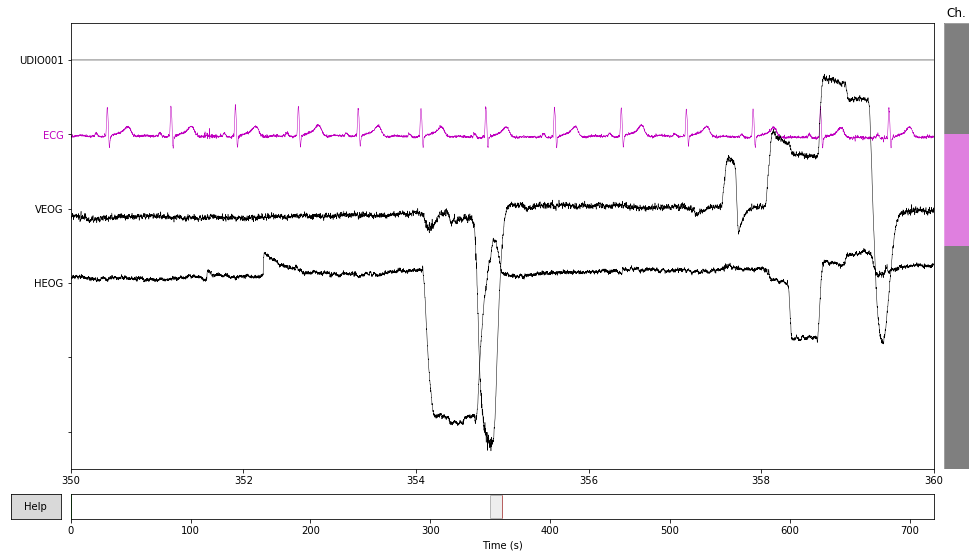

In [8]:
raw.plot(proj=False, order=[0, 306, 307, 308], n_channels=6, start=350, duration=10, scalings=scalings);

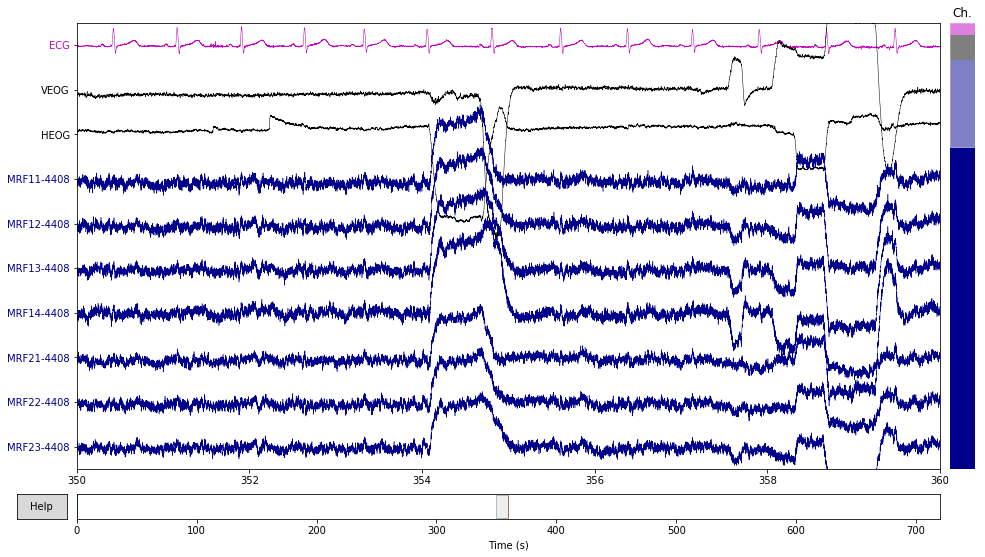

In [9]:
raw.plot(proj=False, order=[306, 307, 308] + frontal, n_channels=10, start=350, duration=10, scalings=scalings);

In [10]:
# dataset specific preparation for artifact rejection

annotations_df = pd.DataFrame()
offset = n_times_run1
for idx in [1, 2]:
    csv_fname = op.join(data_path, 'MEG', 'bst_auditory',
                        'events_bad_0%s.csv' % idx)
    df = pd.read_csv(csv_fname, header=None,
                     names=['onset', 'duration', 'id', 'label'])
    print('Events from run {0}:'.format(idx))
    print(df)

    df['onset'] += offset * (idx - 1)
    annotations_df = pd.concat([annotations_df, df], axis=0)

saccades_events = df[df['label'] == 'saccade'].values[:, :3].astype(int)

# Conversion from samples to times:
onsets = annotations_df['onset'].values / raw.info['sfreq']
durations = annotations_df['duration'].values / raw.info['sfreq']
descriptions = annotations_df['label'].values

annotations = mne.Annotations(onsets, durations, descriptions)
raw.annotations = annotations
del onsets, durations, descriptions

Events from run 1:
     onset  duration  id label
0     7625      2776   1   BAD
1   142459       892   1   BAD
2   216954       460   1   BAD
3   345135      5816   1   BAD
4   357687      1053   1   BAD
5   409101      3736   1   BAD
6   461110       179   1   BAD
7   479866       426   1   BAD
8   764914     11500   1   BAD
9   798174      6589   1   BAD
10  846880      5383   1   BAD
11  858863      5136   1   BAD
Events from run 2:
     onset  duration  id    label
0        9      5583   1      BAD
1     9256      3114   1      BAD
2    14287      3456   1      BAD
3   116432       228   1      BAD
4   134489      1329   1      BAD
5   464527      4727   1      BAD
6   494136      4519   1      BAD
7   749288       189   1      BAD
8   788623      7937   1      BAD
9    21179         0   1  saccade
10   72993         0   1  saccade
11  134527         0   1  saccade
12  196555         0   1  saccade
13  249894         0   1  saccade
14  343357         0   1  saccade
15  400771     

### Signal-Space Projection (SSP)

The Signal-Space Projection (SSP) is one approach to rejection of external disturbances in software. Unlike many other noise-cancellation approaches, SSP does not require additional reference sensors to record the disturbance fields. Instead, SSP relies on the fact that the magnetic field distributions generated by the sources in the brain have spatial distributions sufficiently different from those generated by external noise sources. Furthermore, it is implicitly assumed that the linear space spanned by the significant external noise patters has a low dimension.

https://mne-tools.github.io/stable/manual/preprocessing/ssp.html

In [11]:
# computing the projections

saccade_epochs = mne.Epochs(raw, saccades_events, 1, 0., 0.5, preload=True,
                            reject_by_annotation=False)

projs_saccade = mne.compute_proj_epochs(saccade_epochs, n_mag=1, n_eeg=0,
                                        desc_prefix='saccade')

# projs_eog, _ = mne.preprocessing.compute_proj_eog(raw.load_data(), n_mag=1, n_eeg=0)

# using precomputed solution to save time and resources
proj_fname = op.join(data_path, 'MEG', 'bst_auditory', 'bst_auditory-eog-proj.fif')
projs_eog = mne.read_proj(proj_fname)[0]

raw.add_proj(projs_saccade)
raw.add_proj(projs_eog)
del saccade_epochs, saccades_events, projs_eog, projs_saccade  # To save memory

16 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 16 events and 1201 original time points ...
1 bad epochs dropped
No gradiometers found. Forcing n_grad to 0
Adding projection: axial-saccade-PCA-01
    Read a total of 1 projection items:
        EOG-axial-998--0.200-0.200-PCA-01 (1 x 274)  idle
1 projection items deactivated
1 projection items deactivated


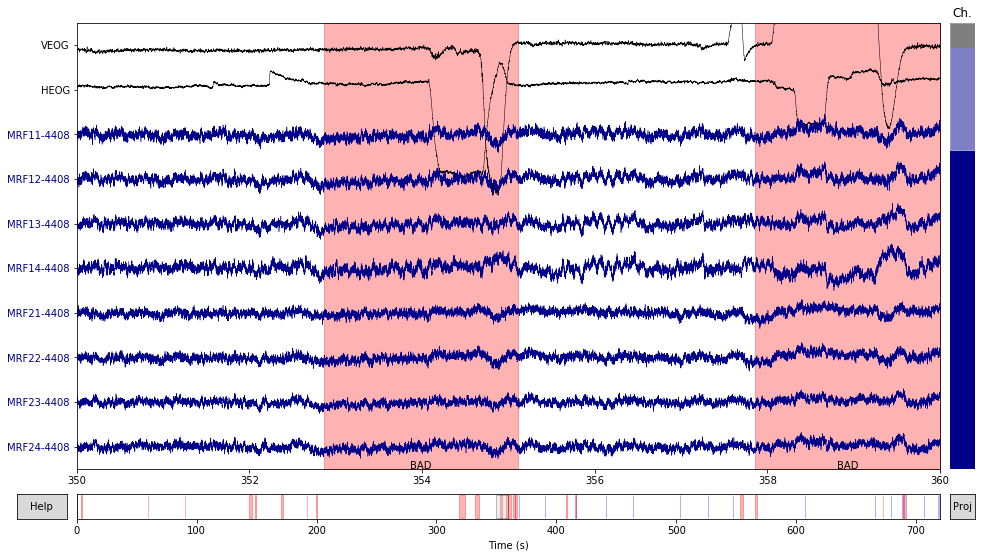

In [12]:
raw.plot(proj=True, order=[307, 308] + frontal, n_channels=10, start=350, scalings=scalings);

### Filtering the data

* removing 60 hz power line artifact using narrowband notch filter
~~~python
meg_picks = mne.pick_types(raw.info, meg=True, eeg=False)
raw.plot_psd(tmax=np.inf, picks=meg_picks)
notches = np.arange(60, 181, 60)
raw.notch_filter(notches, phase='zero-double', fir_design='firwin2')
raw.plot_psd(tmax=np.inf, picks=meg_picks)
~~~

* removing high frequency signal 
~~~python
raw.filter(None, 100., h_trans_bandwidth=0.5, filter_length='10s',
           phase='zero-double', fir_design='firwin2')
~~~

### Epoching and averaging

In [13]:
tmin, tmax = -0.1, 0.5
event_id = dict(standard=1, deviant=2)
reject = dict(mag=4e-12, eog=250e-6)
# find events
events = mne.find_events(raw, stim_channel='UPPT001')

480 events found
Event IDs: [1 2]


In [14]:
# dataset specific event timing
sound_data = raw[raw.ch_names.index('UADC001-4408')][0][0]
onsets = np.where(np.abs(sound_data) > 2. * np.std(sound_data))[0]
min_diff = int(0.5 * raw.info['sfreq'])
diffs = np.concatenate([[min_diff + 1], np.diff(onsets)])
onsets = onsets[diffs > min_diff]
assert len(onsets) == len(events)
diffs = 1000. * (events[:, 0] - onsets) / raw.info['sfreq']
print('Trigger delay removed (μ ± σ): %0.1f ± %0.1f ms'
      % (np.mean(diffs), np.std(diffs)))
events[:, 0] = onsets
del sound_data, diffs

Trigger delay removed (μ ± σ): -14.0 ± 0.3 ms


### Dopping noisy channels

In [15]:
raw.info['bads'] = ['MLO52-4408', 'MRT51-4408', 'MLO42-4408', 'MLO43-4408']

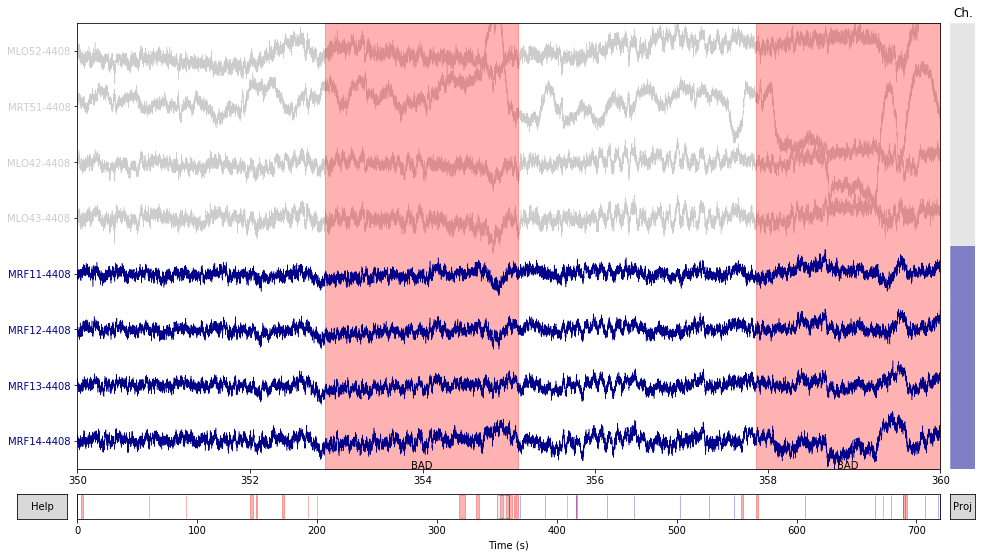

In [16]:
raw.plot(proj=True, order=bad_channels + frontal[:4], n_channels=8, start=350, scalings=scalings);

In [17]:
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                       exclude='bads')

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=False,
                    proj=True)

480 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 2)
2 projection items activated


In [18]:
epochs.drop_bad()
epochs_standard = mne.concatenate_epochs([epochs['standard'][range(40)],
                                          epochs['standard'][182:222]])
epochs_standard.load_data()  # Resampling to save memory.
epochs_standard.resample(600, npad='auto')
epochs_deviant = epochs['deviant'].load_data()
epochs_deviant.resample(600, npad='auto')
del epochs, picks

Loading data for 480 events and 1441 original time points ...
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on MAG : ['MLP52-4408']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['HEOG']
    Rejecting  epoch based on EOG : ['HEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on MAG : ['MLP52-4408']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['HEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based on EOG : ['HEOG']
    Rejecting  epoch based on EOG : ['VEOG']
    Rejecting  epoch based

### Computing averages for each condition

In [19]:
evoked_std = epochs_standard.average()
evoked_dev = epochs_deviant.average()
del epochs_standard, epochs_deviant

#### Unfiltered epochs

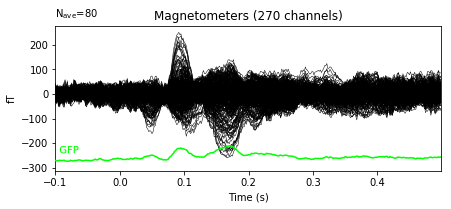

In [20]:
evoked_std.plot(window_title='Standard', gfp=True, time_unit='s');

In [21]:
# for speed and memory, low pass filtering done on epochs
for evoked in (evoked_std, evoked_dev):
    evoked.filter(l_freq=None, h_freq=40., fir_design='firwin')

Setting up low-pass filter at 40 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 199 samples (0.332 sec) selected
Setting up low-pass filter at 40 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 199 samples (0.332 sec) selected


#### After filtering

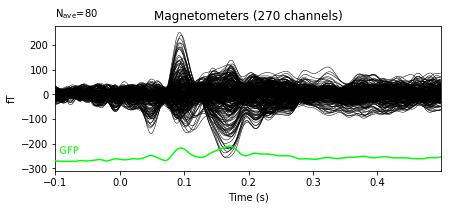

In [22]:
evoked_std.plot(window_title='Standard', gfp=True, time_unit='s');

#### Let's review the results

Standard


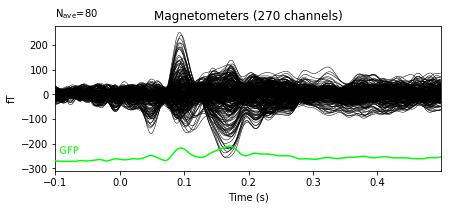

Deviant


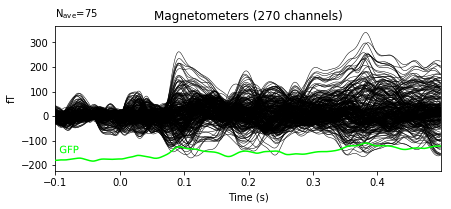

In [24]:
print('Standard')
evoked_std.plot(window_title='Standard', gfp=True, time_unit='s')

print('Deviant')
evoked_dev.plot(window_title='Deviant', gfp=True, time_unit='s');

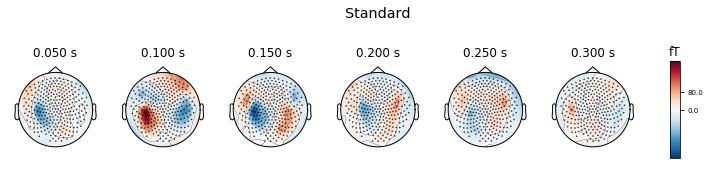

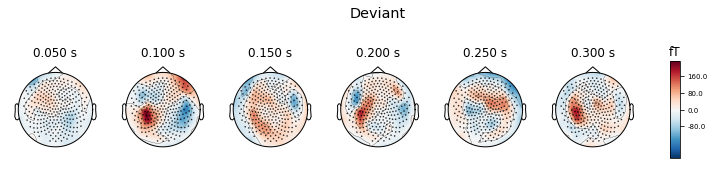

In [25]:
times = np.arange(0.05, 0.301, 0.05)

evoked_std.plot_topomap(times=times, title='Standard', time_unit='s')

evoked_dev.plot_topomap(times=times, title='Deviant', time_unit='s');

### Mismatch negativity
Difference between standard and deviant stimuli

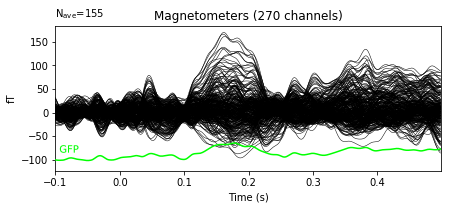

In [26]:
evoked_difference = combine_evoked([evoked_dev, -evoked_std], weights='equal')
evoked_difference.plot(window_title='Difference', gfp=True, time_unit='s');

### Visualising signal sources on a cortical surface

### Forward solution


~~~python
src = mne.setup_source_space(subject, spacing='ico4',
                             subjects_dir=subjects_dir, overwrite=True)
model = mne.make_bem_model(subject=subject, ico=4, conductivity=[0.3],
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)
fwd = mne.make_forward_solution(evoked_std.info, trans=trans, src=src,
                                bem=bem)
~~~

reading transformation files
~~~python

trans_fname = op.join(data_path, 'MEG', 'bst_auditory',
                      'bst_auditory-trans.fif')
trans = mne.read_trans(trans_fname)
~~~

reading precomputed files
~~~python
fwd_fname = op.join(data_path, 'MEG', 'bst_auditory',
                    'bst_auditory-meg-oct-6-fwd.fif')
fwd = mne.read_forward_solution(fwd_fname)
~~~

~~~python
reject = dict(mag=4e-12)
cov = mne.compute_raw_covariance(raw_erm, reject=reject)
inv = mne.minimum_norm.make_inverse_operator(evoked_std.info, fwd, cov)
snr = 3.0
lambda2 = 1.0 / snr ** 2
del fwd
~~~

### Dynamic statistical parametric maps (dSPM) source localisation

~~~python
stc_standard = mne.minimum_norm.apply_inverse(evoked_std, inv, lambda2, 'dSPM')
brain = stc_standard.plot(subjects_dir=subjects_dir, subject=subject,
                          surface='inflated', time_viewer=False, hemi='lh',
                          initial_time=0.1, time_unit='s')
del stc_standard, brain
~~~

#### STANDARD
![title](https://mne-tools.github.io/stable/_images/sphx_glr_plot_brainstorm_auditory_009.png)

#### DEVIANT
![title](https://mne-tools.github.io/stable/_images/sphx_glr_plot_brainstorm_auditory_010.png)

#### MISMATCH (difference)
![title](https://mne-tools.github.io/stable/_images/sphx_glr_plot_brainstorm_auditory_011.png)

source: https://mne-tools.github.io/stable/auto_tutorials/plot_brainstorm_auditory.html